### Naive predictions and Random Forest Baseline

For a baseline model, this notebook implements:
- Naive method of forecasting where it uses the most recent newarrival available
- RandomForest method, simply considering the data basically as cross-sectional data.

In [21]:
import numpy as np
import pandas as pd

data = pd.read_csv('../../data/data.csv', engine='pyarrow').drop_duplicates(subset=['Id','year']).drop(['Country_o','Country_d','iso_d','iso_o', ''], axis=1)

#### Preprocessing

In [22]:
# filter out missing data
data = data[data.year < 2022]

# there are some countries that are contiguous but aren't marked as so. this corrects that
data[data.Id.isin(['SSDETH', 'ETHSSD','SSDUGA','UGASSD','CODUGA','UGACOD','SSNSSD','SSDSSN','CODCOG','COGCOD'])].contig = 1

# all observations must have at least one value greater than c
c = 100
#data = data.groupby('Id', as_index=False).filter(lambda x: x['newarrival'].max() > c)

data['year'] = pd.to_datetime(data['year'], format='%Y')
data = data.set_index(['year', 'Id'])
data.index.levels[1].freq = "Y"
#data = data['y']
data = data.sort_index()

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_2193/720787505.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data.Id.isin(['SSDETH', 'ETHSSD','SSDUGA','UGASSD','CODUGA','UGACOD','SSNSSD','SSDSSN','CODCOG','COGCOD'])].contig = 1


Specify train and test sets:

In [23]:
end_train = '2016-01-01'
end_val = '2016-01-01'

data_train = data.loc[:end_train, :].copy()
# data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()

#### Naive method- Baseline approach

In [24]:
def filter_multi(df,col,val):
    col_index = pd.Series(data.index.names)[(pd.Series(data.index.names) == col)].index.tolist()[0]
    return np.in1d(df.index.get_level_values(col_index), [val])

In [25]:
# naive prediction
def naive_prediction(series, h):
    last_val = series.iloc[-1]
    pred =  np.repeat(last_val, h)
    return pred

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

# rolling window rmse
def rolling_rmse(series, window_len, h):
    series_len = len(series)
    n_of_forecasts = (series_len - (window_len + h) + 1)

    if n_of_forecasts < 1:
        raise ValueError
    
    errors = np.array([])
    errors.shape = (0, 3)

    for i in range(n_of_forecasts):
        window = series.iloc[i:(i + window_len)]
        forecast = naive_prediction(window, h)
        actual = series[(i + window_len):(i + window_len + h)].values
        
        rmse_error = ((forecast - actual)**2)**.5
        errors = np.vstack([errors, rmse_error])

    return pd.DataFrame(errors, columns = np.array([*range(3)])+1).melt(var_name='horizon',value_name='naive')

# rolling window predictions
def rolling_prediction(series, window_len, h):
    series_len = len(series)
    
    n_of_forecasts = (series_len - (window_len + h) + 1)
    
    if n_of_forecasts < 1:
        raise ValueError
    
    errors = np.array([])
    errors.shape = (0, 3)

    actual = []
    forecast = []

    for i in range(n_of_forecasts):
        window = series.iloc[i:(i + window_len)]
        forecast.append(naive_prediction(window, h)[0])
        actual.append(series[(i + window_len):(i + window_len + h)].values[0])

    return pd.DataFrame({'pred':forecast,'actual':actual})

Text(0, 0.5, 'New arrivals')

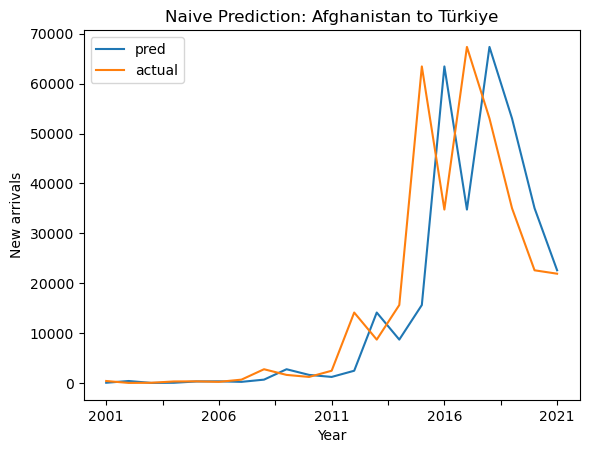

In [27]:
ax = data[filter_multi(data, 'Id','AFGTUR')].groupby('Id').newarrival.apply(lambda x: rolling_prediction(x, 1,1)).reset_index().drop(['Id','level_1'],axis=1)
ax.index = pd.Series([*range(2001, 2022)]).astype(str)
ax = ax.plot.line(title='Naive Prediction: Afghanistan to Türkiye')
ax.set_xlabel("Year")
ax.set_ylabel("New arrivals")

In [26]:
# serial
naive_metrics = data_test.newarrival.groupby(level='Id').apply(lambda x:rolling_rmse(x, 1, 3)).groupby('horizon').mean()
naive_metrics

,naive
horizon,
1,96.276234
2,123.511530
3,112.609371


#### RF Baseline

In [144]:
# def data_prep(df, h):
#     new_cols = []
#     for h_i in range(h):
#         df[h_i + 1] = df.groupby(level='Id').newarrival.shift(-(h_i + 1))
#         new_cols.append((h_i+1))
    
#     id_vars = data_train.columns.values[~pd.Series(data_train.columns.values).isin(new_cols)].tolist()
    
#     df = df.melt(id_vars = id_vars, var_name = 'horizon', value_name = 'newarrival_h').dropna()
#     id_vars.append('horizon')
#     X = df[id_vars]
#     y = df['newarrival_h']
#     return X, y

# X_train, y_train = data_prep(data_train, 3)
# X_test, y_test = data_prep(data_test, 3)

In [31]:
def multi_shift(df, shift_range, columns):
    shifted_data = []
    for shift_value in range(shift_range.start, shift_range.stop):
        shifted = df[columns].shift(shift_value)
        shifted_data.append(shifted)
    shifted_df = pd.concat(shifted_data, axis=1, keys=[f'Shift_{shift_value}' for shift_value in range(shift_range.start, shift_range.stop)])
    
    return shifted_df

In [34]:
from multiprocesspandas import applyparallel

lagged_df = pd.concat([data_train, data_train.groupby('Id').apply(lambda x: multi_shift(x, range(1,5), ['newarrival','dead_o']))], axis=1)

lagged_df.dropna(inplace=True)

lagged_df.columns = [col[0] + '_' +  col[1] if type(col) is tuple else col for col in lagged_df.columns ]

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_2193/1783254202.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  lagged_df = pd.concat([data_train, data_train.groupby('Id').apply(lambda x: multi_shift(x, range(1,5), ['newarrival','dead_o']))], axis=1)


In [55]:
data.reset_index()

,year,Id,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,PR_o,...,newarrival,index0asylum,contig,comlang_off,comlang_ethno,colony,comcol,col45,smctry,dist
0,2000-01-01,ABWAFG,0.091,3.544,36636.95,0.005,1,193.0,0,4,...,0.0,0,0,0,0,0,0,0,0,13257.814453
1,2000-01-01,ABWAGO,0.091,3.544,36636.95,0.005,1,193.0,0,4,...,0.0,0,0,0,0,0,0,0,0,9516.913086
2,2000-01-01,ABWALB,0.091,3.544,36636.95,0.005,1,193.0,0,4,...,0.0,0,0,0,0,0,0,0,0,9091.742188
3,2000-01-01,ABWAND,0.091,3.544,36636.95,0.005,1,193.0,0,4,...,0.0,0,0,1,0,0,0,0,0,7572.788086
4,2000-01-01,ABWARE,0.091,3.544,36636.95,0.005,1,193.0,0,4,...,0.0,0,0,0,0,0,0,0,0,12735.011719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840835,2021-01-01,ZWEWBG,15.492,60.737,2151.97,0.025,0,390759.0,1,6,...,0.0,0,0,0,0,0,0,0,0,8068.000000
840836,2021-01-01,ZWEWSM,15.492,60.737,2151.97,0.025,0,390759.0,1,6,...,0.0,0,0,1,1,0,0,0,0,14465.198242
840837,2021-01-01,ZWEYEM,15.492,60.737,2151.97,0.025,0,390759.0,1,6,...,0.0,0,0,0,0,0,1,0,0,3971.474121
840838,2021-01-01,ZWEZAF,15.492,60.737,2151.97,0.025,0,390759.0,1,6,...,0.0,0,1,1,1,0,0,0,0,2186.205811


496860

array(['2004-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2006-01-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2012-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2014-01-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

h1 = data.groupby('Id').newarrival.shift(-1).reset_index()[data.reset_index().year.isin(lagged_df.reset_index().year.unique())].newarrival

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(lagged_df, h1)

RandomForestRegressor(n_jobs=-1)

In [146]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, rf.predict(X_test), squared=False)

def compute_rmse(model, X_test, y_test):
    y_test_pred = rf.predict(X_test)
    rmse = ((y_test_pred - y_test)**2)**.5
    return pd.concat([rmse, X_test.horizon], axis=1)

rf_metrics = compute_rmse(rf, X_test, y_test).groupby('horizon').mean().rename({'newarrival_h':'RandomForest'}, axis=1)

The Theil ratio $ (T) $ is as follows:
$$ T = \frac{RMSE_X}{RMSE_{RW}} $$
Where $ X $ is the model under investigation 

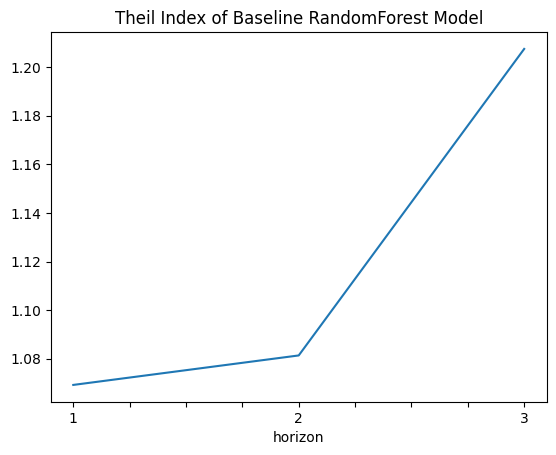

In [33]:
def compute_theil(df, naive_col, model_col):
    theil = df[model_col]/df[naive_col]
    theil.index = theil.index.astype(str)
    return theil

baseline_theil = compute_theil(pd.concat([naive_metrics,rf_metrics],axis=1), 'naive','RandomForest').plot(title='Theil Index of Baseline RandomForest Model', x='horizon')

#### Baseline 2

To implement a slightly more intelligent baseline, we'll use lagged features aggregated at a stock level. We'll also create a stock transformer, so that $\delta$ (the discount factor for the past) and $w$ (how many time periods to consider when aggregating) can be hyperparameterized.

In [8]:
def moving_average(data, p, delta):
    """
    Computes the moving average of the past p periods, including the period itself, with a discount factor.

    Parameters:
        data (pd.Series or pd.DataFrame): The input series or DataFrame.
        p (int): The number of periods to consider for the moving average.
        delta (float): The discount factor, between 0 and 1.

    Returns:
        pd.Series or pd.DataFrame: The moving average of the input data.
    """
    if isinstance(data, pd.Series):
        return moving_average_series(data, p, delta)
    elif isinstance(data, pd.DataFrame):
        return data.apply(lambda col: moving_average_series(col, p, delta))
    else:
        raise ValueError("Unsupported data type. Expected pd.Series or pd.DataFrame.")

def moving_average_series(series, p, delta):
    """
    Computes the moving average of the past p periods, including the period itself, with a discount factor.

    Parameters:
        series (pd.Series): The input series.
        p (int): The number of periods to consider for the moving average.
        delta (float): The discount factor, between 0 and 1.

    Returns:
        pd.Series: The moving average of the series.
    """
    series = np.asarray(series)
    n = len(series)
    moving_averages = np.full(n, np.nan)
    if n >= p:
        weights = (delta ** np.arange(p-1, -1, -1)).astype(np.float64)
        weights /= np.sum(weights, dtype=np.float64)
        moving_averages[p-1:] = np.convolve(series, weights, mode='valid')
    return pd.Series(moving_averages)

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import FeatureUnion

class StockAggregator(BaseEstimator, TransformerMixin):
    def __init__(self, p, delta):
        self.p = p
        self.delta = delta
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.groupby('Id').apply(lambda x: moving_average(x, p=self.p, delta=self.delta))
        X_transformed.columns = X.columns.values + '_stock'
        X_transformed.index = X.index
        return pd.concat([X, X_transformed], axis=1)

# https://stackoverflow.com/questions/25539311/custom-transformer-for-sklearn-pipeline-that-alters-both-x-and-y

class Dropna():

    def fit(self, X, y):
        return self

    def fit_transform(self, X, y):
        
        mask = (np.isnan(np.array(X)).any(-1) | np.isnan(np.array(y)))
        if hasattr(X, 'loc'):
            X = X.loc[~mask]
        else:
            X = X[~mask]
        if hasattr(y, 'loc'):
            y = y.loc[~mask]
        else:
            y = y[~mask]
        
        return X, y   ###### make fit_transform return X and y
    
    def transform(self, X):
        
        mask = np.isnan(X).any(-1)
        if hasattr(X, 'loc'):
            X = X.loc[~mask]
        else:
            X = X[~mask]
        
        return X


from sklearn import pipeline
from sklearn.base import clone
from sklearn.utils import _print_elapsed_time
from sklearn.utils.validation import check_memory

class Pipeline(pipeline.Pipeline):

    def _fit(self, X, y=None, **fit_params_steps):
        self.steps = list(self.steps)
        self._validate_steps()
        memory = check_memory(self.memory)

        fit_transform_one_cached = memory.cache(pipeline._fit_transform_one)

        for (step_idx, name, transformer) in self._iter(
            with_final=False, filter_passthrough=False
        ):
                        
            if transformer is None or transformer == "passthrough":
                with _print_elapsed_time("Pipeline", self._log_message(step_idx)):
                    continue

            try:
                # joblib >= 0.12
                mem = memory.location
            except AttributeError:
                mem = memory.cachedir
            finally:
                cloned_transformer = clone(transformer) if mem else transformer

            X, fitted_transformer = fit_transform_one_cached(
                cloned_transformer,
                X,
                y,
                None,
                message_clsname="Pipeline",
                message=self._log_message(step_idx),
                **fit_params_steps[name],
            )
            
            if isinstance(X, tuple):    ###### unpack X if is tuple X = (X,y)
                X, y = X
            
            self.steps[step_idx] = (name, fitted_transformer)
        
        return X, y
    
    def fit(self, X, y=None, **fit_params):
        fit_params_steps = self._check_fit_params(**fit_params)
        Xt = self._fit(X, y, **fit_params_steps)
        
        if isinstance(Xt, tuple):    ###### unpack X if is tuple X = (X,y)
            Xt, y = Xt 
        
        with _print_elapsed_time("Pipeline", self._log_message(len(self.steps) - 1)):
            if self._final_estimator != "passthrough":
                fit_params_last_step = fit_params_steps[self.steps[-1][0]]
                self._final_estimator.fit(Xt, y, **fit_params_last_step)

        return self

In [9]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

stock_feat = ['CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'CL_o', 'PR_o', 'typeOfViolence_o', 
'Nyear_conflict_o','Nyear_log_o', 'dead_log_o', 'Nyear_conf_o', 'CPI_d', 
'GDP_PP_d', 'GDP_PPP_d','PR_d', 'CL_d','typeOfViolence_d', 'best_est_d', 
'Nyear_conflict_d', 'Nyear_log_d', 'dead_log_d', 'Nyear_conf_d', 'dead_d', 'newarrival', 'index0asylum']


In [10]:
from xgboost import XGBRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from skopt import BayesSearchCV,  plots
from skopt.space import Real, Integer, Categorical

# Specify pipeline
stock_pipe = ColumnTransformer([
    ("stock", StockAggregator(p=2, delta=1), stock_feat)],
    remainder='passthrough')

preprocess_pipeline = Pipeline([
    ('stock', stock_pipe),
    ("dropna", Dropna())
])

xgb_pipeline = Pipeline([
    ('pre', preprocess_pipeline),
    ('xgb', XGBRegressor())
])


In [122]:
X, y = preprocess_pipeline.fit_transform(data_train, data_train.newarrival.groupby('Id').shift(-1).reset_index(drop=True))

In [175]:
y

1        12955.0
2          359.0
3          504.0
4         1081.0
5            3.0
          ...   
33563      226.0
33564      299.0
33565      230.0
33566      346.0
33567     7964.0
Name: newarrival, Length: 31593, dtype: float64

In [127]:

# XGB parameters to search over
param_grid={
        # 'pre__stock_pipe__stock__p': Integer(1,10),
        # 'pre__stock_pipe__stock__delta': Real(.25,10),
        'n_estimators': [400],
        # Learning rate for boosting.
        "learning_rate": Real(.01, .5, prior="log-uniform"),
        # Maximum tree depth for base learners.
        'max_depth': Integer(5, 25, prior="uniform"),
        # minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree.
        "min_child_weight": Integer(10, 200, prior="uniform"),
        # % of rows taken to build the tree
        "subsample": Real(.6,1, prior="uniform"),
        # number of columns used by each tree
        "colsample_bytree": Real(.3,1, prior="uniform"),
        # regularization parameter- Minimum loss reduction required to make a further partition on a leaf node of the tree.
        "gamma" : Real(0, .5)
        }

xgb_search = BayesSearchCV(XGBRegressor(), param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose = 1, n_iter=30)

xgb_search.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                             'gamma': Real(low=0, high=0.5, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=0.5, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=5, high=25, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=10, high=200, prior='uniform', transform='normalize'),
                             'n_estimators': [400],
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize')},
              verbose=1)

<Axes: >

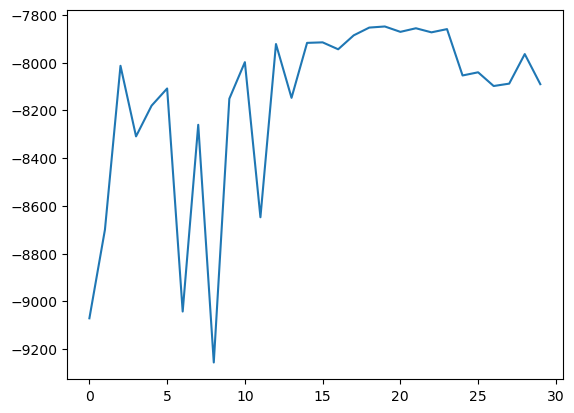

In [128]:
pd.Series(xgb_search.cv_results_['mean_test_score']).plot()

In [143]:
xgb_search.best_estimator_.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1.0,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.22852775776227785,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.08588711454741363,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 12,
 'max_leaves': 0,
 'min_child_weight': 87,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 400,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.9316148767738646,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

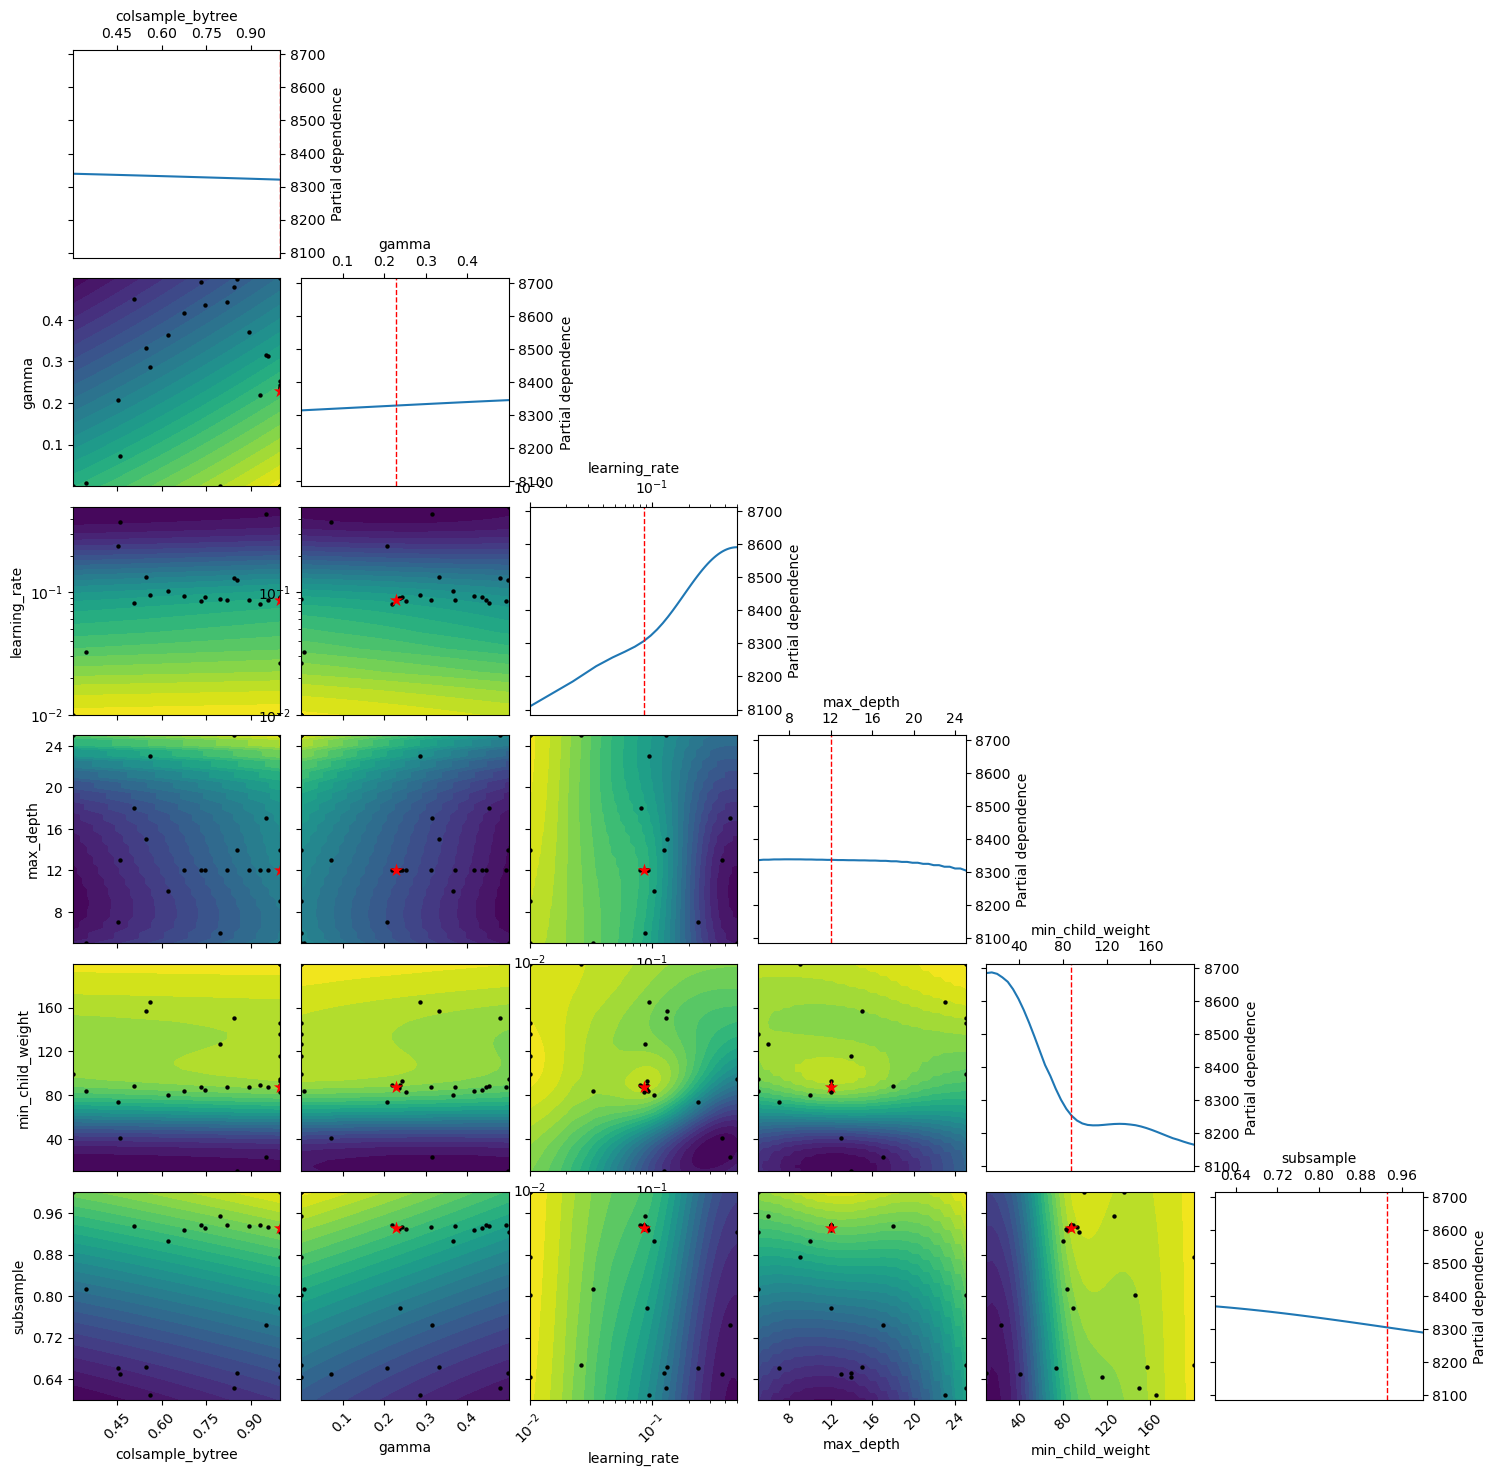

In [130]:
# import matplotlib.pyplot as plt
# plots.plot_objective(xgb_search.optimizer_results_[0],
#                      size = 2.5, levels = 25)
# plt.show()

In [137]:
X_test, y_test = preprocess_pipeline.fit_transform(data_test, data_test.newarrival.groupby('Id').shift(-1).reset_index(drop=True))

In [141]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, xgb_search.predict(X_test), squared=False)

18262.408491236558

In [159]:
AFGTUR_X, AFGTUR_Y = preprocess_pipeline.fit_transform(data_test[filter_multi(data_test, 'Id','AFGTUR')], data_test[filter_multi(data_test, 'Id','AFGTUR')].newarrival.groupby('Id').shift(-1) )

In [171]:
xgb_AFGTUR = pd.DataFrame({'pred':xgb_search.predict(AFGTUR_X), 'actual': AFGTUR_Y})
xgb_AFGTUR.index = pd.Series([*range(2017, 2021)]).astype(str)